# mapping-challenge-mask_rcnn-prediction-submission
![CrowdAI-Logo](https://github.com/crowdAI/crowdai/raw/master/app/assets/images/misc/crowdai-logo-smile.svg?sanitize=true)

This notebook contains the code for making predictions from the model trained in [Training.ipynb](Training.ipynb) (or by using the [released pretrained model](https://www.crowdai.org/challenges/mapping-challenge/dataset_files)) for the [crowdAI Mapping Challenge](https://www.crowdai.org/challenges/mapping-challenge).

This code is adapted from the [Mask RCNN]() tensorflow implementation available here : [https://github.com/matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN).

First we begin by importing all the necessary dependencies : 

In [106]:
import os
import sys
import time
import numpy as np
import skimage.io
import random

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3.
# I submitted a pull request https://github.com/cocodataset/cocoapi/pull/50
# If the PR is merged then use the original repo.
# Note: Edit PythonAPI/Makefile and replace "python" with "python3".
#  
# A quick one liner to install the library 
# !pip install git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import coco #a slightly modified version

from mrcnn.evaluate import build_coco_results, evaluate_coco
from mrcnn.dataset import MappingChallengeDataset
from mrcnn import visualize

import zipfile
import urllib
import shutil
import glob
import tqdm
import random
import matplotlib.pyplot as plt

## Dataset location 
Now we expect that you have downloaded all the files in the datasets section and untar-ed them to have the following structure :
```
├── data
|   ├── pretrained_weights.h5 (already included in this repository)
│   ├── test
│   │   └── images/
│   │   └── annotation.json
│   ├── train
│   │   └── images/
│   │   └── annotation.json
│   └── val
│       └── images/
│       └── annotation.json
```

In [25]:
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "pretrained_weights.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "data", "test_images")

In [27]:
IMAGE_DIR

'/Users/corybhowmik/Documents/CS230-Final-Project/data/test_images'

# Instantitate Inference Config

In [28]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5
    NUM_CLASSES = 1 + 1  # 1 Background + 1 Building
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320
    NAME = "crowdai-mapping-challenge"
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           crowdai-mapping-challenge
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

# Instantiate Model

In [29]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model_path = PRETRAINED_MODEL_PATH

# or if you want to use the latest trained model, you can use : 
# model_path = model.find_last()[1]

model.load_weights(model_path, by_name=True)

# Run Prediction on a single Image (and visualize results)

In [30]:
class_names = ['BG', 'building'] # In our case, we have 1 class for the background, and 1 class for building

Processing 5 images
image                    shape: (300, 300, 3)         min:    2.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:    2.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:    2.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:    2.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (5, 320, 320, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (5, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (5, 25575, 4)         min:   -1.13492  max:    1.93429  float32


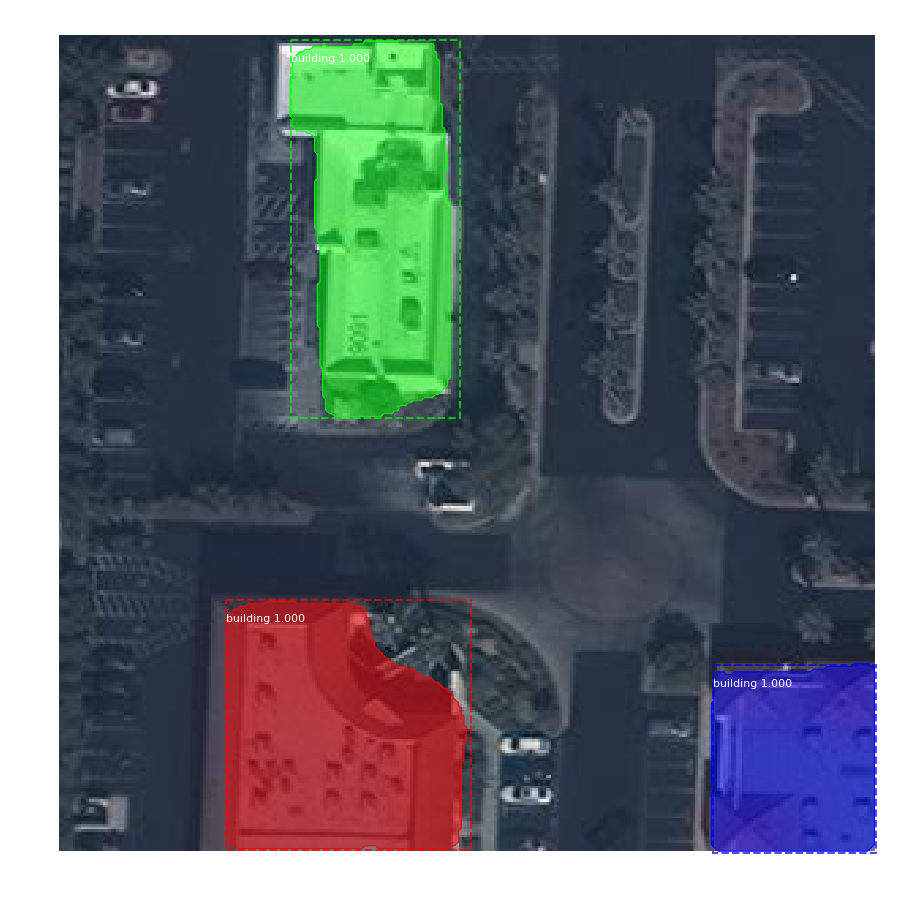

In [33]:
file_names = next(os.walk(IMAGE_DIR))[2]
random_image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

predictions = model.detect([random_image]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

p = predictions[0]
visualize.display_instances(random_image, p['rois'], p['masks'], p['class_ids'], 
                            class_names, p['scores'])

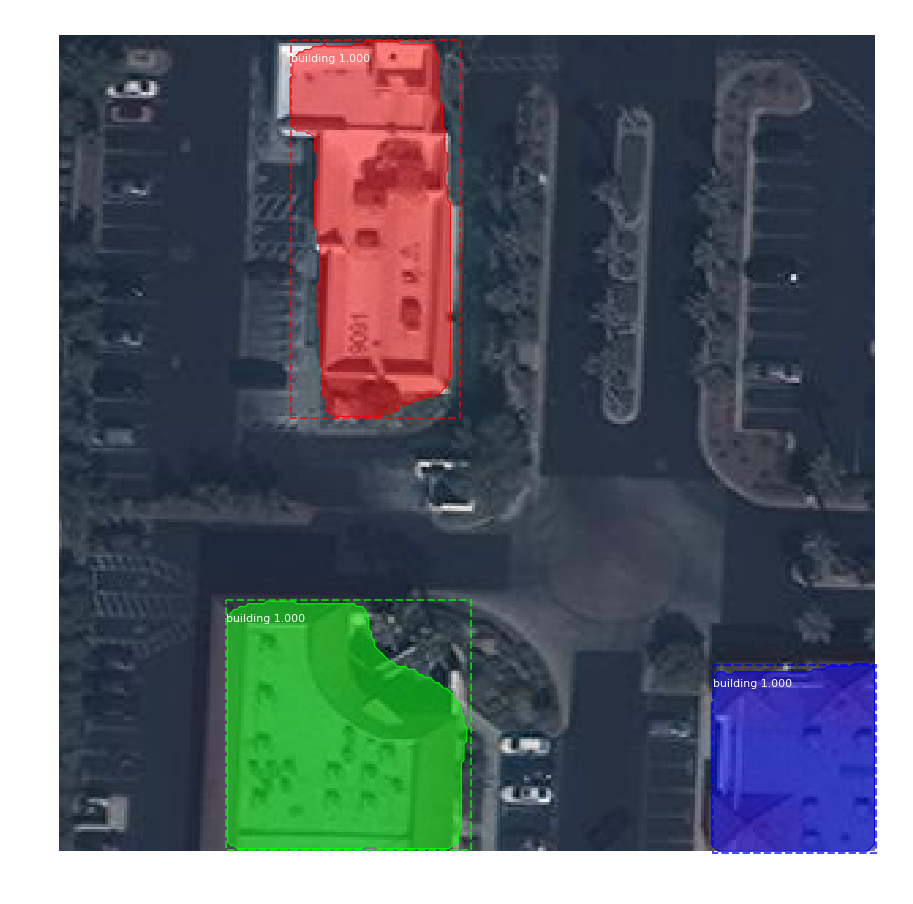

In [89]:
visualize.display_instances(random_image, p['rois'], p['masks'], p['class_ids'], 
                            class_names, p['scores'])

# Run predictions on all the images in the test set

Note that this step might take some time depending on the GPU(s) you have and your system configuration. On a single NVIDIA TitanX it take about 1.25 hours to generate all the predictions.

In [57]:
# Gather all JPG files in the test set as small batches
files_all = glob.glob(os.path.join(IMAGE_DIR, "*.jpg"))

# Testing on 102 randomly chosen test images.
random.shuffle(files_all)
files = files_all[0:101]
ALL_FILES=[]
_buffer = []
for _idx, _file in enumerate(files):
    if len(_buffer) == config.IMAGES_PER_GPU * config.GPU_COUNT:
        ALL_FILES.append(_buffer)
        _buffer = []
    else:
        _buffer.append(_file)

if len(_buffer) > 0:
    ALL_FILES.append(_buffer)

In [59]:
# Iterate over all the batches and predict
_final_object = []
for files in tqdm.tqdm(ALL_FILES):
    images = [skimage.io.imread(x) for x in files]
    predoctions = model.detect(images, verbose=0)
    for _idx, r in enumerate(predoctions):
        _file = files[_idx]
        image_id = int(_file.split("/")[-1].replace(".jpg",""))
        for _idx, class_id in enumerate(r["class_ids"]):
            if class_id == 1:
                mask = r["masks"].astype(np.uint8)[:, :, _idx]
                bbox = np.around(r["rois"][_idx], 1)
                bbox = [float(x) for x in bbox]
                _result = {}
                _result["image_id"] = image_id
                _result["category_id"] = 100
                _result["score"] = float(r["scores"][_idx])
                _mask = maskUtils.encode(np.asfortranarray(mask))
                _mask["counts"] = _mask["counts"].decode("UTF-8")
                _result["segmentation"] = _mask
                _result["bbox"] = [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]]
                _final_object.append(_result)



  0%|          | 0/17 [00:00<?, ?it/s]

  6%|▌         | 1/17 [00:35<09:27, 35.45s/it]

 12%|█▏        | 2/17 [01:12<09:03, 36.26s/it]

 18%|█▊        | 3/17 [01:54<08:52, 38.06s/it]

 24%|██▎       | 4/17 [02:28<08:02, 37.12s/it]

 29%|██▉       | 5/17 [03:04<07:22, 36.89s/it]

 35%|███▌      | 6/17 [03:41<06:45, 36.90s/it]

 41%|████      | 7/17 [04:11<05:58, 35.89s/it]

 47%|████▋     | 8/17 [04:43<05:19, 35.45s/it]

 53%|█████▎    | 9/17 [05:11<04:37, 34.64s/it]

 59%|█████▉    | 10/17 [05:40<03:58, 34.04s/it]

 65%|██████▍   | 11/17 [06:08<03:21, 33.50s/it]

 71%|███████   | 12/17 [06:36<02:45, 33.02s/it]

 76%|███████▋  | 13/17 [07:05<02:10, 32.70s/it]

 82%|████████▏ | 14/17 [07:33<01:37, 32.37s/it]

 88%|████████▊ | 15/17 [08:03<01:04, 32.21s/it]

 94%|█████████▍| 16/17 [08:35<00:32, 32.24s/it]

100%|██████████| 17/17 [09:04<00:00, 32.03s/it]



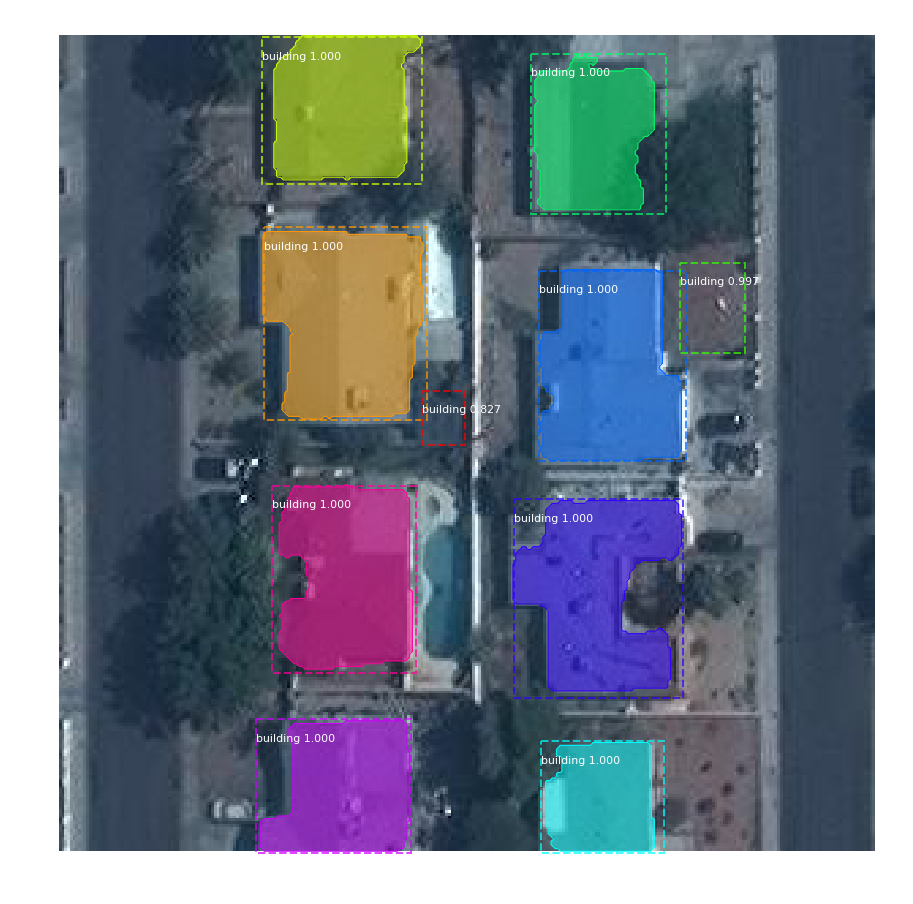

In [113]:
pp = predoctions[1]
file_to_display = files[1]
image_to_display = skimage.io.imread(os.path.join(IMAGE_DIR, file_to_display))
visualize.display_instances(image_to_display, pp['rois'], pp['masks'], pp['class_ids'], class_names, pp['scores'])

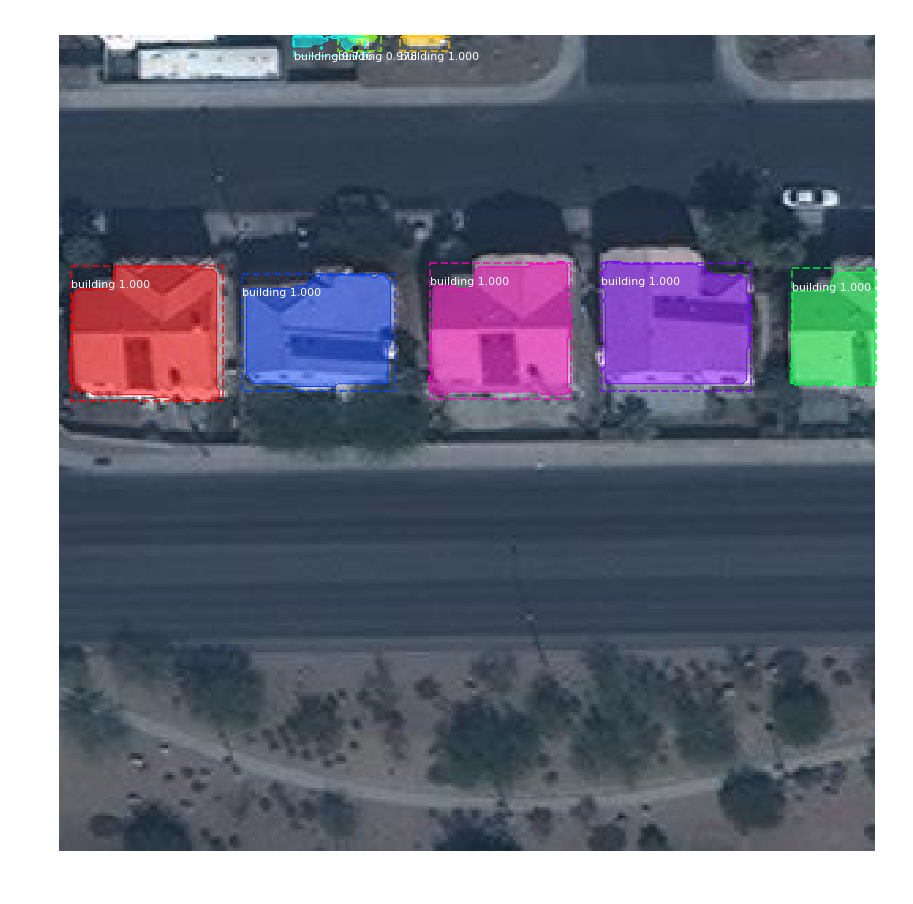

In [114]:
pp = predoctions[2]
file_to_display = files[2]
image_to_display = skimage.io.imread(os.path.join(IMAGE_DIR, file_to_display))
visualize.display_instances(image_to_display, pp['rois'], pp['masks'], pp['class_ids'], class_names, pp['scores'])


*** No instances to display *** 



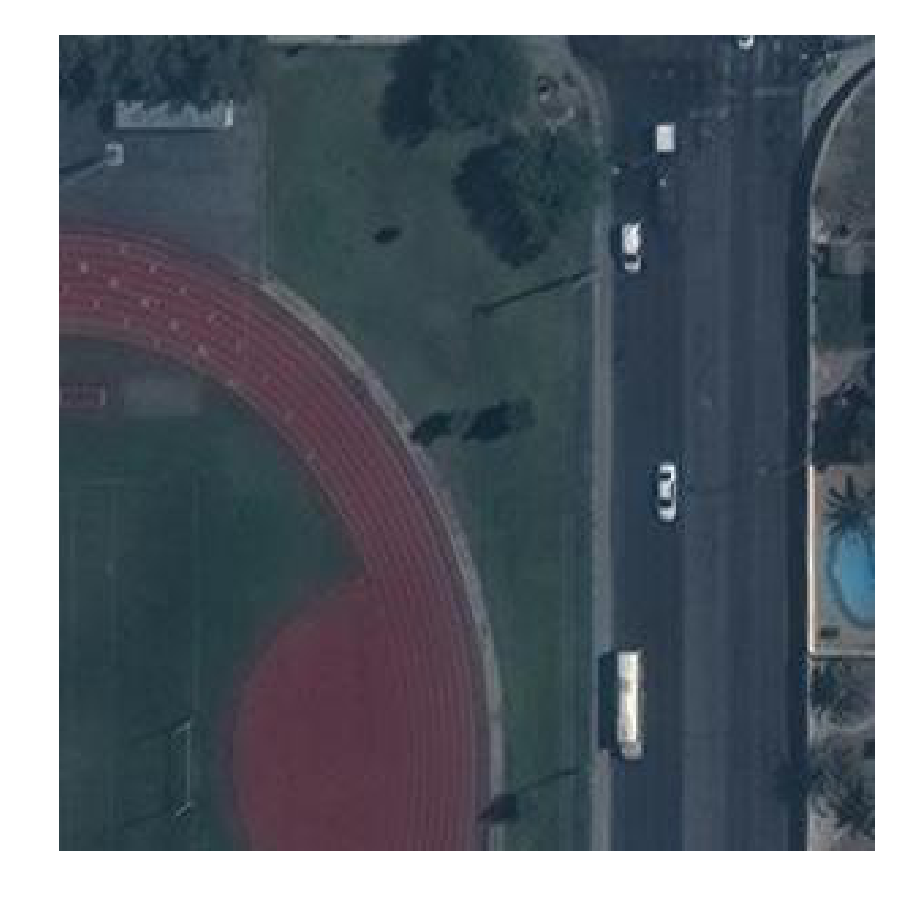

In [112]:
pp = predoctions[3]
file_to_display = files[3]
image_to_display = skimage.io.imread(os.path.join(IMAGE_DIR, file_to_display))
visualize.display_instances(image_to_display, pp['rois'], pp['masks'], pp['class_ids'], class_names, pp['scores'])

# Write prediction files to JSON and submit to crowdAI

In [43]:
fp = open("predictions.json", "w")
import json
print("Writing JSON...")
fp.write(json.dumps(_final_object))
fp.close()

Writing JSON...


In [ ]:
import crowdai
api_key = "YOUR-CROWDAI-API-KEY-HERE"
challenge = crowdai.Challenge("crowdAIMappingChallenge", api_key)
result = challenge.submit("predictions.json")

# Author
Sharada Mohanty [sharada.mohanty@epfl.ch](sharada.mohanty@epfl.ch)